In [1]:
import os
import shutil
import glob

import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint


from tensorflow.keras import layers
from tensorflow import keras 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Dropout, Conv2D, Activation, Dense
import tensorflow as tf
from tensorflow.keras.metrics import top_k_categorical_accuracy


import urllib.request



In [2]:
## quickdraw 라는 api 설치한다. (리스트 쉽게 뽑을 수 있고, 그룹별 이미지 확인도 쉬운편)
!pip install quickdraw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
## quick draw 의 클래스 이름을 불러온다.
from quickdraw import QuickDrawData

qd = QuickDrawData()
classes = qd.drawing_names
## class 를 임의로 20개만 추출한다. (colab 의 ram 사용 문제)
classes_rd = random.sample(classes, 10)
print('추출한 class 갯수 : ', len(classes_rd))

추출한 class 갯수 :  10


In [5]:
## class 이름중간의 빈칸은 _ 로 바꿔준다.
classes_rd = [c.replace(' ', '_') for c in classes_rd]
print(classes_rd)

['floor_lamp', 'knee', 'goatee', 'violin', 'pond', 'canoe', 'rabbit', 'compass', 'shorts', 'rifle']


In [6]:
# data 라는 폴더를 만들어준다. (colab)
# 이전에 로딩해두었던 데이터는 모두 지우고 새로한다.
if os.path.exists('data'):
  shutil.rmtree('data')

!mkdir data

In [7]:
## 위에서 random으로 추출한 class 들의 이미지 파일을 다운로드 받는다.
## numpy bitmap 형식으로 다운 받는다.
def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes_rd:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    ## 위에서 만들어준 data 라는 폴더에 저장한다.
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [8]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/floor%20lamp.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/knee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/goatee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/violin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pond.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/canoe.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/compass.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/shorts.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rifle.npy


In [10]:
## colab 의 임시 폴더인 'data' 에 저장해둔 데이터 불러와 train, test 및 x, y 로 분리하기
## 데이터 불러올때 순서에 맞춰 label 맞추기

## test set 비율은 20%, 각 이미지 셋에서 불러오는 이미지 갯수는 50000개로 default 설정함
def load_data(root, vfold_ratio=0.2, max_items_per_class=50000):
  all_files = glob.glob(os.path.join(root, '*.npy'))

  ## 28 x 28 x 1 의 비트맵 이미지임
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []

  for idx, file in enumerate(all_files):
    ## 확장자 npy 인 파일을 numpy의 load 메서드 이용해 부른다.
    data = np.load(file)
    ## 각 클래스의 이미지중 정해진 개수만 읽는다.
    data = data[0:max_items_per_class, :]
    ## 파일 순서대로 라벨링 해준다.
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

    ## class name도 순서대로 쌓아준다.(위에서한 label 과 순서를 맞추는 의미가 있음)
    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None

  ## 데이터의 순서를 랜덤으로 섞어준다. (random permutation)
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  ## train 과 test set 으로 분리해준다.
  ## 입력받은 vfold_ratio를 사용함
  vfold_size = int(x.shape[0]/100 * (vfold_ratio * 100))

  ## test set
  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  ## train set
  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]

  return x_train, y_train, x_test, y_test, class_names

In [11]:
x_train, y_train, x_test, y_test, class_names = load_data('data')

In [12]:
print('class 갯수 : ', len(class_names))
print('x_train 의 Shape : {}, y_train 의 Shape : {}'.format(x_train.shape, y_train.shape))
print('x_test 의 Shape : {}, y_test의 Shape : {}'.format(x_test.shape, y_test.shape))

class 갯수 :  10
x_train 의 Shape : (400000, 784), y_train 의 Shape : (400000,)
x_test 의 Shape : (100000, 784), y_test의 Shape : (100000,)


floor_lamp


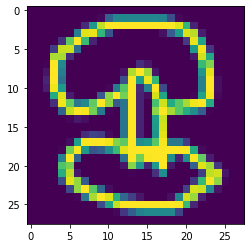

In [13]:
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [14]:
## image 크기는 28, 28, 1 으로 한다.
image_size = 28
num_classes = len(class_names)

x_train_rs = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test_rs = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

## x 값들을 정규화한다.

#-1 ~ 1 로 정규화
x_train_rs = (x_train_rs - 127.5) / 127.5
x_test_rs = (x_test_rs - 127.5) / 127.5

'''
x_train_rs = x_train_rs / 255
x_test_rs = x_test_rs / 255
'''

y_train_rs = keras.utils.to_categorical(y_train, num_classes)
y_test_rs = keras.utils.to_categorical(y_test, num_classes)

In [15]:
print('x_train 의 Shape : {}, y_train 의 Shape : {}'.format(x_train_rs.shape, y_train_rs.shape))
print('x_test 의 Shape : {}, y_test 의 Shape : {}'.format(x_test_rs.shape, y_test_rs.shape))

x_train 의 Shape : (400000, 28, 28, 1), y_train 의 Shape : (400000, 10)
x_test 의 Shape : (100000, 28, 28, 1), y_test 의 Shape : (100000, 10)


In [16]:
## CNN 모델을 구성한다.

## Alex-Net 의 구조를 참고하되 2xGPU 는 구현하지 않고 1xGPU만을 사용하는 것으로 한다.
## 5개의 Conv Layer + 1개의 Flatten Layer + 2개의 Dense Layer + 1개의 출력층
## Normalize Layer 는 LRN 대신 BatchNormal 로 적용함

con_filter = 32

model = keras.Sequential()
# 첫번째 Conv layer (maxpooling 없음 : 입력값이 28x28x1 이라 5개층을 쌓으려면 pooling 층이 4개여야 함)
model.add(Conv2D(con_filter, (3, 3), padding='same', input_shape=(x_train_rs.shape[1], x_train_rs.shape[1], 1), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# 두번째 Conv layer
model.add(Conv2D(con_filter * 2, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# 세번째 Conv layer
model.add(Conv2D(con_filter * 4, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# 네번째 Conv layer
model.add(Conv2D(con_filter * 8, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(Activation('relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))

# 다섯번째 Conv layer
model.add(Conv2D(con_filter * 16, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(Activation('relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer (2개 반영)
# Dropout Layer (과적합 방지위해 각 Dense Layer 이후에 50% dropout 을 반영)
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax')) 



In [17]:

def top_3_accuracy(x, y):
  t3 = top_k_categorical_accuracy(x, y, 3)
  return t3

learning_rate = 0.001

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose = 1, mode='auto', min_delta=0.005, cooldown=5, min_lr=learning_rate)

earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=4)
callbacks = [earlystop]

adam = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy', top_3_accuracy])

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0

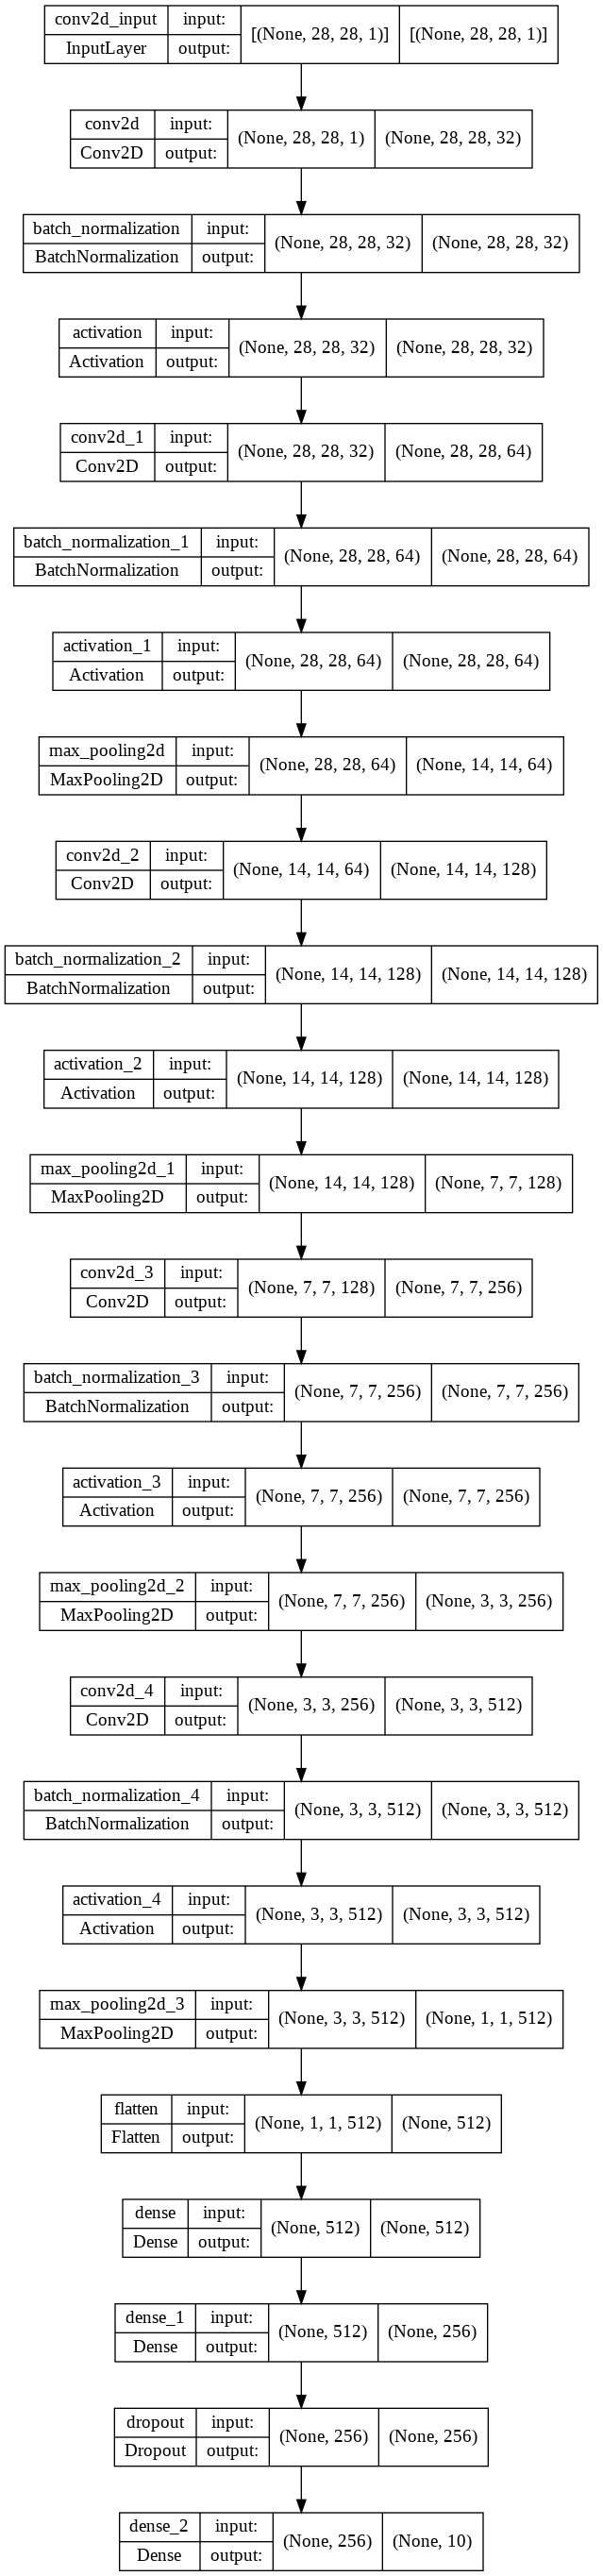

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
history = model.fit(x=x_train_rs, y=y_train_rs, validation_split=0.1, batch_size=128, verbose=2, callbacks=callbacks, epochs=50)

Epoch 1/50
2813/2813 - 45s - loss: 0.3206 - accuracy: 0.9046 - top_3_accuracy: 0.9664 - val_loss: 0.2409 - val_accuracy: 0.9271 - val_top_3_accuracy: 0.9754 - 45s/epoch - 16ms/step
Epoch 2/50
2813/2813 - 34s - loss: 0.2192 - accuracy: 0.9350 - top_3_accuracy: 0.9761 - val_loss: 0.2384 - val_accuracy: 0.9279 - val_top_3_accuracy: 0.9763 - 34s/epoch - 12ms/step
Epoch 3/50
2813/2813 - 34s - loss: 0.1879 - accuracy: 0.9438 - top_3_accuracy: 0.9789 - val_loss: 0.2063 - val_accuracy: 0.9388 - val_top_3_accuracy: 0.9774 - 34s/epoch - 12ms/step
Epoch 4/50
2813/2813 - 34s - loss: 0.1641 - accuracy: 0.9505 - top_3_accuracy: 0.9815 - val_loss: 0.1985 - val_accuracy: 0.9401 - val_top_3_accuracy: 0.9771 - 34s/epoch - 12ms/step
Epoch 5/50
2813/2813 - 34s - loss: 0.1432 - accuracy: 0.9564 - top_3_accuracy: 0.9833 - val_loss: 0.1889 - val_accuracy: 0.9447 - val_top_3_accuracy: 0.9795 - 34s/epoch - 12ms/step
Epoch 6/50
2813/2813 - 34s - loss: 0.1248 - accuracy: 0.9617 - top_3_accuracy: 0.9856 - val_los

In [19]:
score = model.evaluate(x_test_rs, y_test_rs, verbose=0)
print('Loss : {:.4f}, Accuracy : {:.4f}%'.format(score[0], score[1]*100))

Loss : 0.2464, Accuracy : 94.0710%


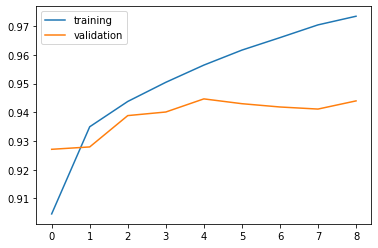

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

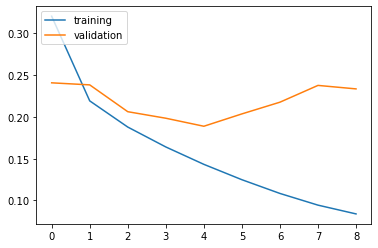

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

예측치 상위 5개 명단 :  ['canoe', 'rifle', 'pond', 'floor_lamp', 'violin']
실제 낙서의 이름 :  canoe


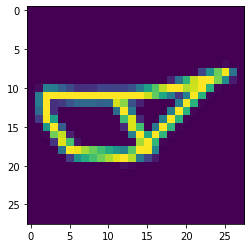

In [22]:
## test 를 집어넣고, 예상값 상위 5개 출력해보기

idx = random.randint(0, len(x_test))
img = x_test_rs[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
pred_x_top5 = [class_names[x] for x in ind]


print('예측치 상위 5개 명단 : ', pred_x_top5)
print('실제 낙서의 이름 : ', class_names[int(y_test[idx])])

In [23]:
with open('class_names.txt', 'w') as file:
  for item in class_names:
    file.write("{}\n".format(item))

In [24]:
!pip install tensorflowjs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 3.8 MB/s 
     |████████████████████████████████| 40 kB 6.9 MB/s 
     |████████████████████████████████| 1.0 MB 10.6 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 438 kB 74.5 MB/s 
     |████████████████████████████████| 511.7 MB 3.8 kB/s 
     |████████████████████████████████| 1.6 MB 64.9 MB/s 
     |████████████████████████████████| 5.8 MB 73.6 MB/s 
     |████████████████████████████████| 5.8 MB 77.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempti

In [25]:
model.save('qdraw_toy.h5')

In [26]:
if os.path.exists('model'):
  shutil.rmtree('model')

!mkdir model
!tensorflowjs_converter --input_format keras qdraw_toy.h5 model/

In [27]:
!cp class_names.txt model/class_names.txt

In [28]:

!zip -r model.zip model
from google.colab import files
files.download('model.zip')


  adding: model/ (stored 0%)
  adding: model/group1-shard1of2.bin (deflated 7%)
  adding: model/group1-shard2of2.bin (deflated 7%)
  adding: model/model.json (deflated 89%)
  adding: model/class_names.txt (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>